# Evaluating temporal profile for each cell type

In [1]:
import sys
import os

myhost = os.uname()[1]
print("Running on Computer: [%s]" %myhost)

sys.path.insert(0, '/home/ifernand/Code/') 
dirname = '/home/ifernand/Cloud_SynthData_Proj'

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import io as sio
import torch
import time
import h5py

# NDN tools
import NDNT
import NDNT.utils as utils
from NDNT.modules.layers import *
from NDNT.networks import *
import NDNT.NDN as NDN
from NTdatasets.conway.synthcloud_datasets import SimCloudData
from NTdatasets.generic import GenericDataset
from ColorDataUtils.multidata_utils import MultiExperiment
import ColorDataUtils.ConwayUtils as CU
from ColorDataUtils import readout_fit
from ColorDataUtils.simproj_utils import *
from NDNT.utils import fit_lbfgs, fit_lbfgs_batch
from NDNT.utils import imagesc   
from NDNT.utils import ss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

%load_ext autoreload
%autoreload 2

Running on Computer: [sc]
Invoking __init__.py for NDNT.utils


## Load Data

In [2]:
out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3_sca=3.hdf5'
with h5py.File(out_file, 'r') as f:
    x_pos = f['x_pos'][:]
    y_pos = f['y_pos'][:]
    cell_key = [str(f['cell_key'][:][i], encoding='utf-8') for i in range(x_pos.shape[0])]
    file_start_pos = list(f['file_start_pos'][:])

In [20]:
cell_type_list = ['X_ON', 'X_OFF', 'V1_Exc_L4', 'V1_Inh_L4', 'V1_Exc_L2/3', 'V1_Inh_L2/3']
cell_idx_dict = {}
cell_NC = []
for i in range(len(cell_type_list)):
    cell = cell_type_list[i]
    cell_idx_dict[cell] = [j for j, val in enumerate(cell_key) if val == cell]
    cell_NC.append(len(cell_idx_dict[cell]))
    print(cell, cell_NC[i])

X_ON 105
X_OFF 109
V1_Exc_L4 607
V1_Inh_L4 187
V1_Exc_L2/3 535
V1_Inh_L2/3 162


In [5]:
#out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3.hdf5'
start    = time.time()
data     = SimCloudData(file_name=out_file, down_sample=2)
end      = time.time()
print('CPU Time', end-start, 'sec')

CPU Time 17.069396495819092 sec


In [6]:
stim_dims = data.stim_dims
num_lags = data.num_lags
L  = stim_dims[1]
print('stim_dims =', stim_dims)
print('num_lags =', num_lags)
print('L =', L)

stim_dims = [1, 60, 60, 1]
num_lags = 12
L = 60


In [7]:
NC = data[0]['robs'].shape[1]
print('Number of cells', NC)

Number of cells 1705


In [8]:
NT = data.NT
print('Number of time points', NT)

Number of time points 170000


In [9]:
pxl_x_pos, pxl_y_pos = deg2pxl(x_pos, y_pos, L, down_sample=2)
mu0s = utils.pixel2grid(np.stack((pxl_x_pos,pxl_y_pos),axis=1), L=L)
print('Spatial mu0:', mu0s.shape)

Spatial mu0: (1705, 2)


## STA

In [10]:
robs = data[:]['robs']*data[:]['dfs']
nspks = torch.sum(robs,axis=0)

In [11]:
sta_arr = np.zeros((num_lags,L,L,NC))
for j in range(num_lags):
    if j == 0:
        sta = (data[:]['stim'].T @ robs)
    else:
        sta = (data[:]['stim'][:-j, ...].T @ robs[j:,:])
    sta_arr[j,:,:,:] = (sta/nspks).reshape([L,L,NC]).detach().cpu().numpy()
    print('Lag', j, 'complete')

Lag 0 complete
Lag 1 complete
Lag 2 complete
Lag 3 complete
Lag 4 complete
Lag 5 complete
Lag 6 complete
Lag 7 complete
Lag 8 complete
Lag 9 complete
Lag 10 complete
Lag 11 complete


In [12]:
sta_arr.shape

(12, 60, 60, 1705)

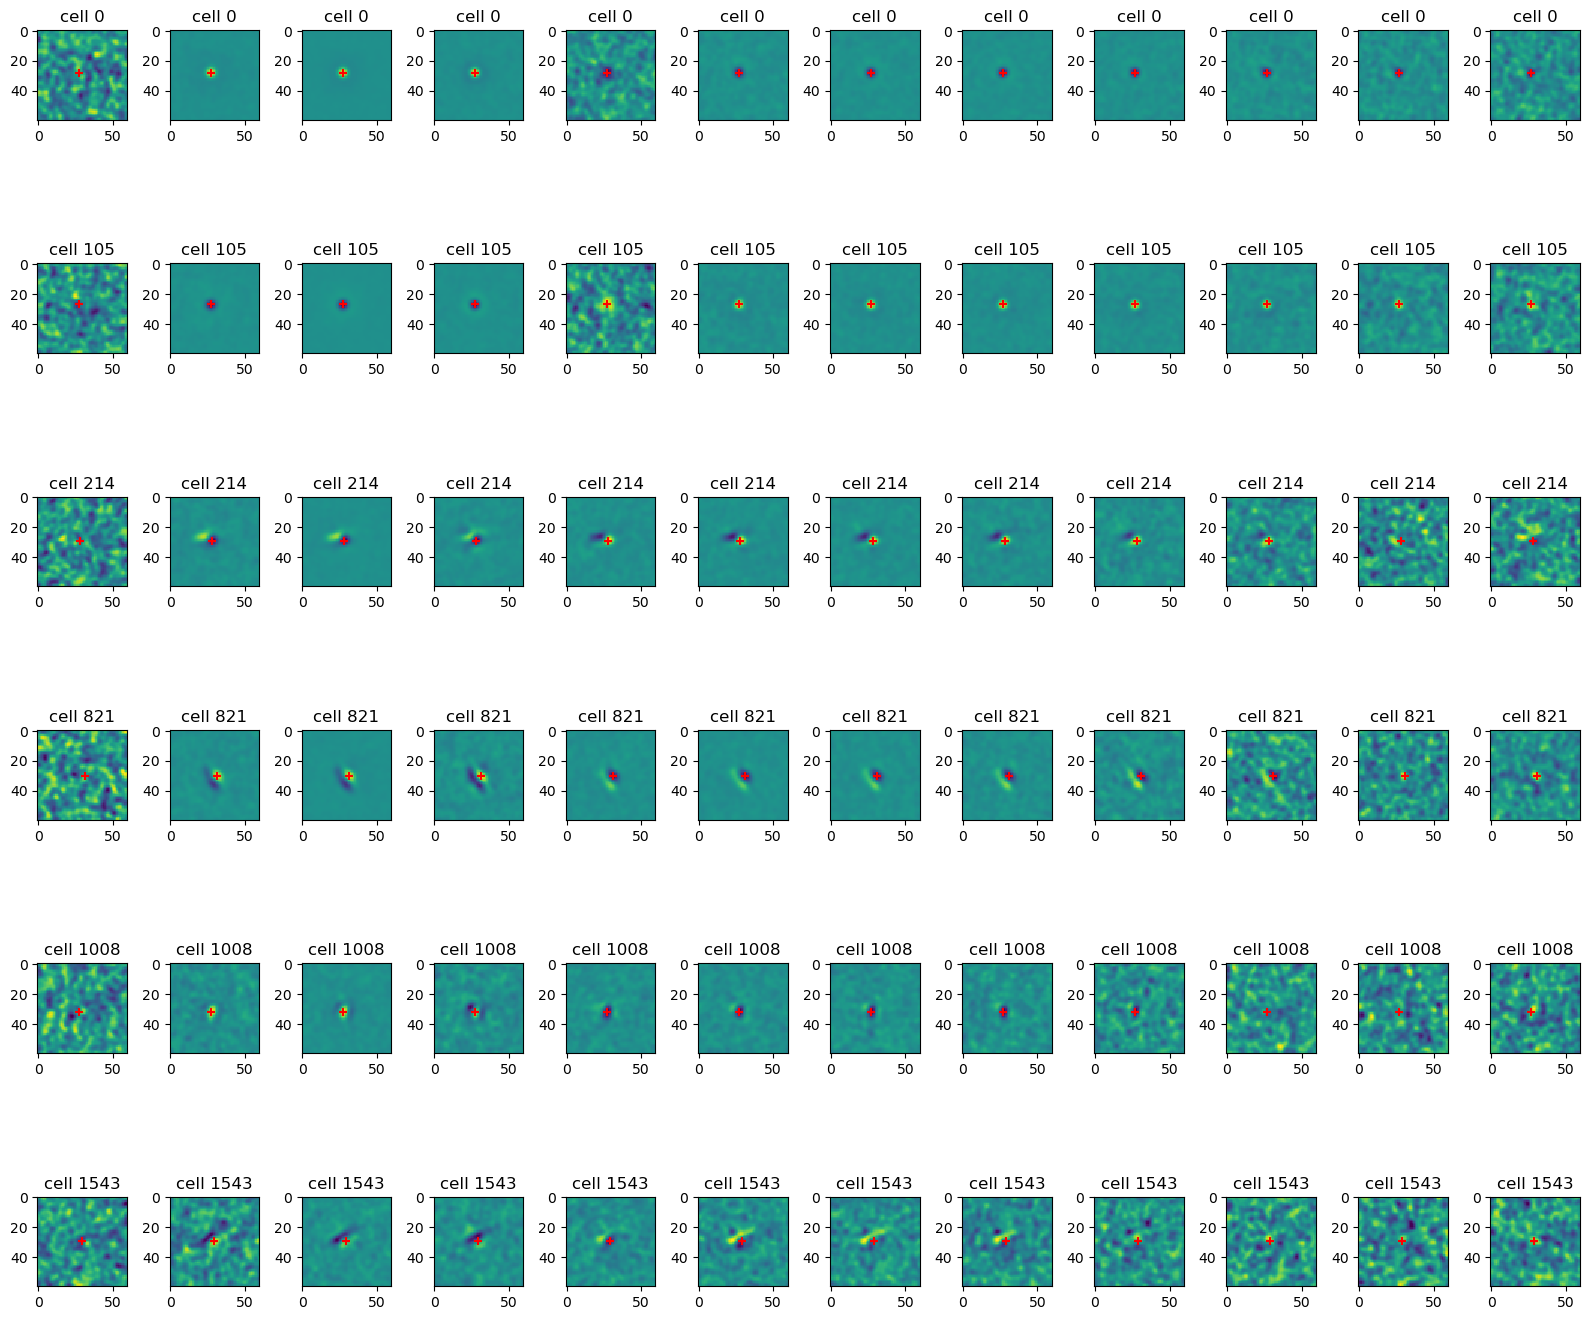

In [15]:
ss(6,12)
k = 1
for i in range(6):
    for j in range(12):
        plt.subplot(6,12,k)
        l = sum(cell_NC[:i])
        imagesc(sta_arr[j,:,:,l])
        plt.scatter(pxl_x_pos[l], pxl_y_pos[l], c='r', s=40, marker='+')
        plt.title('cell '+str(l))
        k += 1
plt.tight_layout()
plt.show()

## Temporal Profiel

In [18]:
ts_arr = np.zeros((num_lags,NC))
for i in range(NC):
    ts_arr[:,i] = sta_arr[:,int(pxl_x_pos[i]), int(pxl_y_pos[i]),i]
print(ts_arr.shape)

(12, 1705)


In [26]:
ts_arr_norm = ts_arr/np.std(ts_arr, axis=0)
print(ts_arr_norm.shape)

(12, 1705)


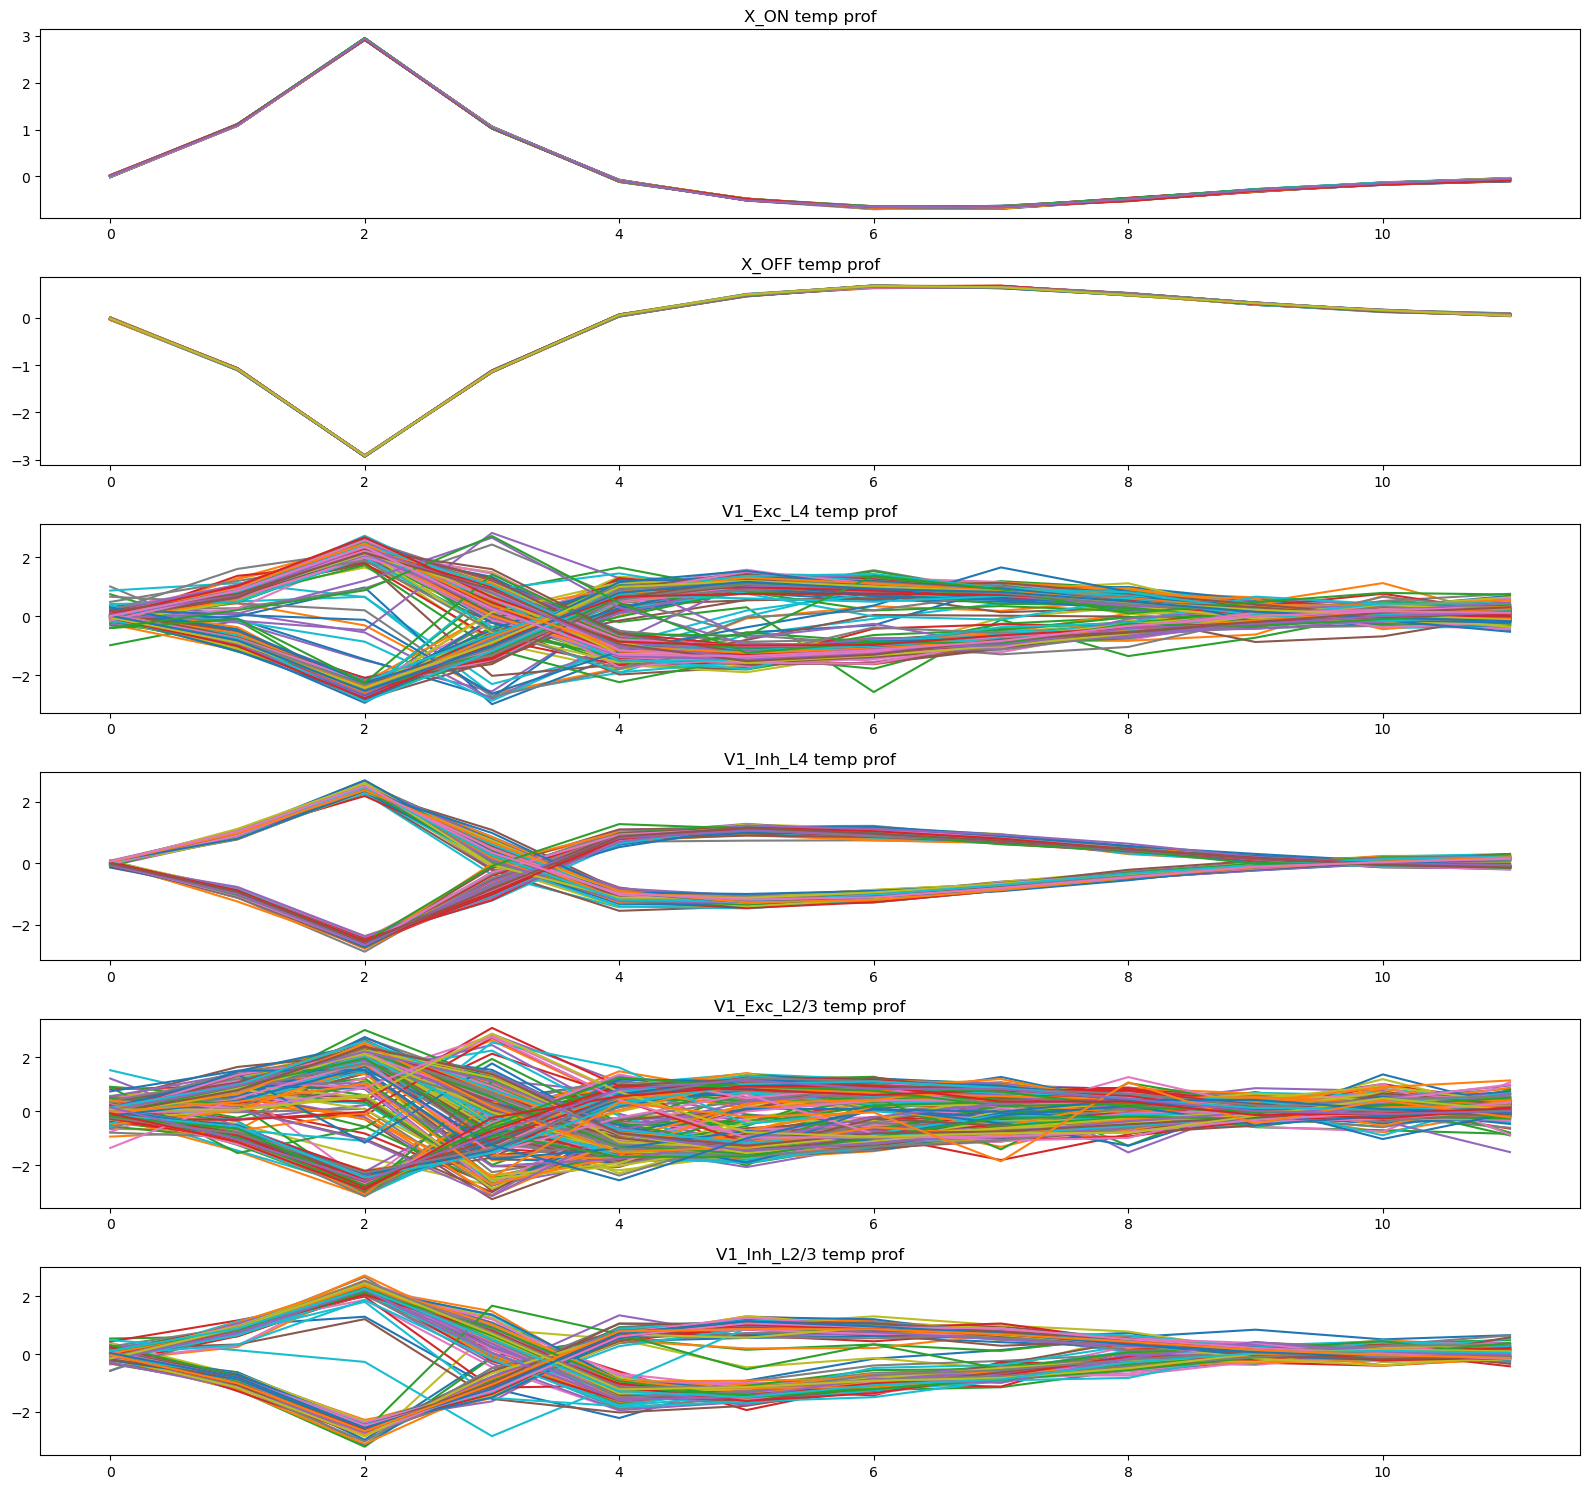

In [27]:
ss(6,1)
for i in range(len(cell_type_list)):
    cell = cell_type_list[i]
    plt.subplot(6,1,i+1)
    for j in range(cell_NC[i]):
        l = cell_idx_dict[cell][j]
        plt.plot(ts_arr_norm[:,l])
    plt.title(cell+' temp prof')
plt.tight_layout()
plt.show()

In [40]:
pos_ts_avg = np.mean(ts_arr_norm[:,X_ON_idx],axis=1)
neg_ts_avg = np.mean(ts_arr_norm[:,X_OFF_idx],axis=1)
print(pos_ts_avg.shape)
print(neg_ts_avg.shape)

(12,)
(12,)


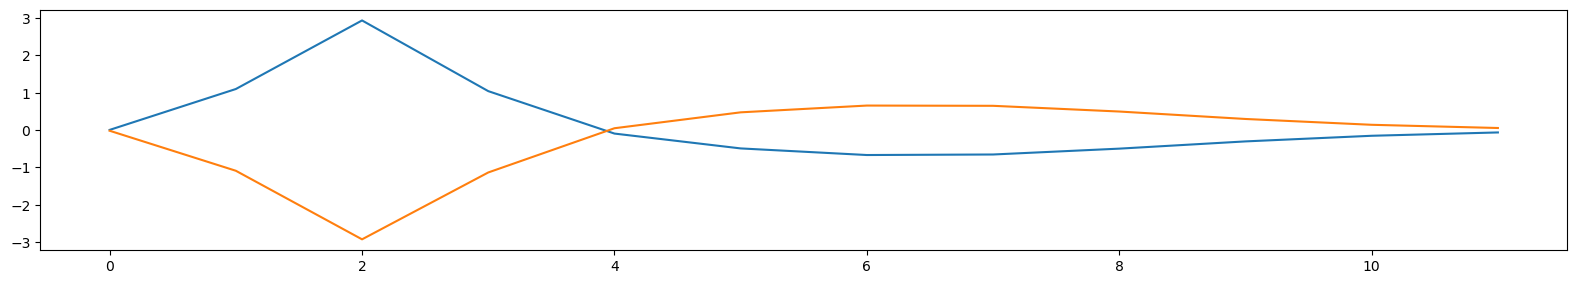

In [41]:
ss()
plt.plot(pos_ts_avg)
plt.plot(neg_ts_avg)

In [61]:
# choose neurons of the same temproal profile (correlation)
pos_corr = np.zeros(cell_NC[2]+cell_NC[3])
neg_corr = np.zeros(cell_NC[2]+cell_NC[3])
for i in range(cell_NC[2]):
    j = cell_idx_dict['V1_Exc_L4'][i]
    pos_corr[i] = np.corrcoef(pos_ts_avg, ts_arr_norm[:,j])[0,1]
    neg_corr[i] = np.corrcoef(neg_ts_avg, ts_arr_norm[:,j])[0,1]
for i in range(cell_NC[3]):
    j = cell_idx_dict['V1_Inh_L4'][i]
    pos_corr[i+cell_NC[2]] = np.corrcoef(pos_ts_avg, ts_arr_norm[:,j])[0,1]
    neg_corr[i+cell_NC[2]] = np.corrcoef(neg_ts_avg, ts_arr_norm[:,j])[0,1]

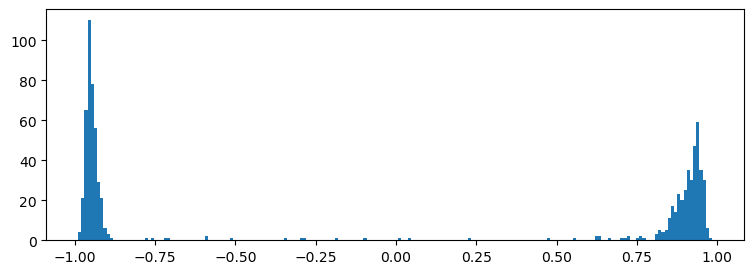

In [111]:
plt.figure(figsize=(9,3))
plt.hist(pos_corr,bins=200)
plt.show()

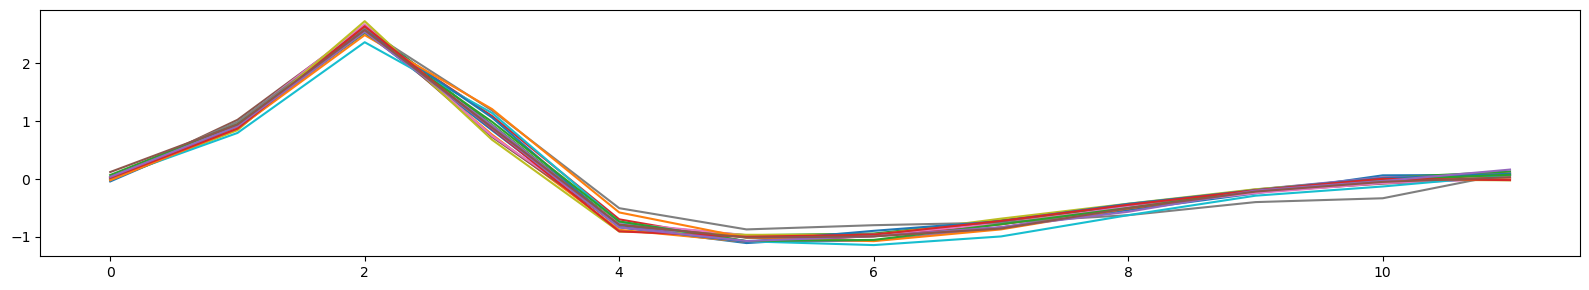

In [96]:
ss()
pos_check = []
for i in range(cell_NC[2]):
    j = cell_idx_dict['V1_Exc_L4'][i]
    if pos_corr[i] >= 0.96:
        pos_check.append(i)
        plt.plot(ts_arr_norm[:,j])
plt.tight_layout()
plt.show()

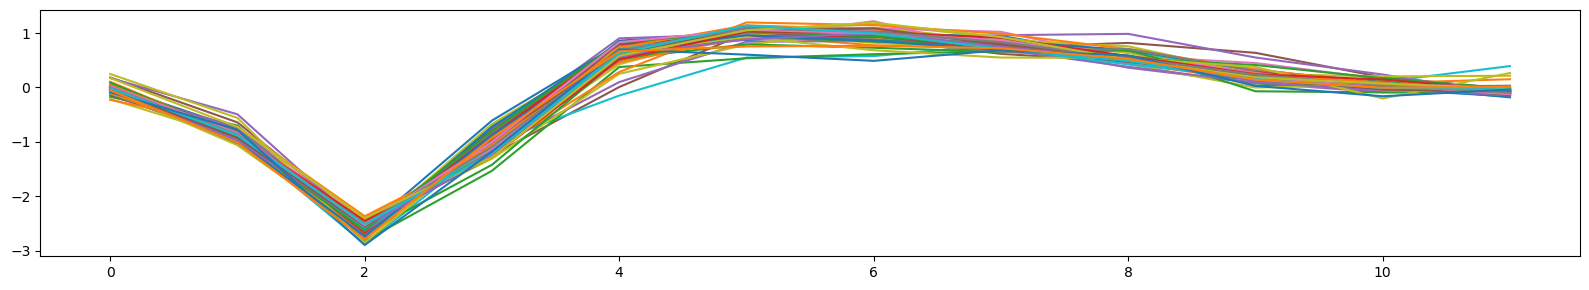

In [97]:
ss()
neg_check = []
for i in range(cell_NC[2]):
    j = cell_idx_dict['V1_Exc_L4'][i]
    if pos_corr[i] <= -0.96:
        neg_check.append(i)
        plt.plot(ts_arr_norm[:,j])
plt.tight_layout()
plt.show()

In [109]:
# choose neurons of the same temproal profile (correlation)
pos_corr_L23 = np.zeros(cell_NC[4]+cell_NC[5])
neg_corr_l23 = np.zeros(cell_NC[4]+cell_NC[5])
for i in range(cell_NC[4]):
    j = cell_idx_dict['V1_Exc_L2/3'][i]
    pos_corr_L23[i] = np.corrcoef(pos_ts_avg, ts_arr_norm[:,j])[0,1]
    neg_corr_l23[i] = np.corrcoef(neg_ts_avg, ts_arr_norm[:,j])[0,1]
for i in range(cell_NC[5]):
    j = cell_idx_dict['V1_Inh_L2/3'][i]
    pos_corr_L23[i+cell_NC[4]] = np.corrcoef(pos_ts_avg, ts_arr_norm[:,j])[0,1]
    neg_corr_l23[i+cell_NC[4]] = np.corrcoef(neg_ts_avg, ts_arr_norm[:,j])[0,1]

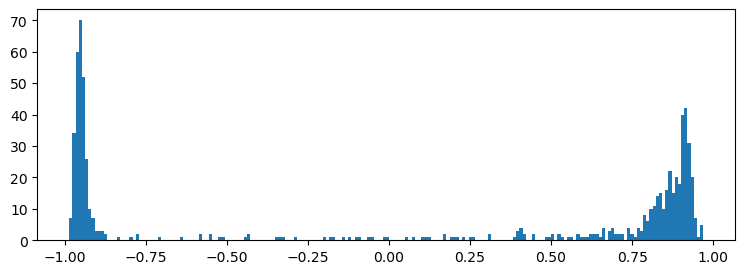

In [112]:
plt.figure(figsize=(9,3))
plt.hist(pos_corr_L23,bins=200)
plt.show()

## Look at model

In [56]:
cnn = NDN.load_model_zip('models/0923_three_layer_model_non-ori_CNN_L4_timemask.ndn')
cnn.block_sample = True

In [57]:
#out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3.hdf5'
L4_idx  = [i for i, val in enumerate(cell_key) if val == 'V1_Exc_L4' or val == 'V1_Inh_L4']
print('Layer 4 cells:', len(L4_idx))
start    = time.time()
data_L4  = SimCloudData(file_name=out_file, down_sample=2, cell_idx=L4_idx, num_lags=11)
end      = time.time()
print('CPU Time', end-start, 'sec')

Layer 4 cells: 794
CPU Time 17.006748914718628 sec


In [58]:
LL = cnn.eval_models(data_L4, data_inds=data_L4.val_blks, device=device, batch_size=2, null_adjusted=True)
print('Log Likelyhood shape', LL.shape)

Eval models: 100%|█████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.36it/s]

Log Likelyhood shape (794,)


Mean LL: 0.5277752


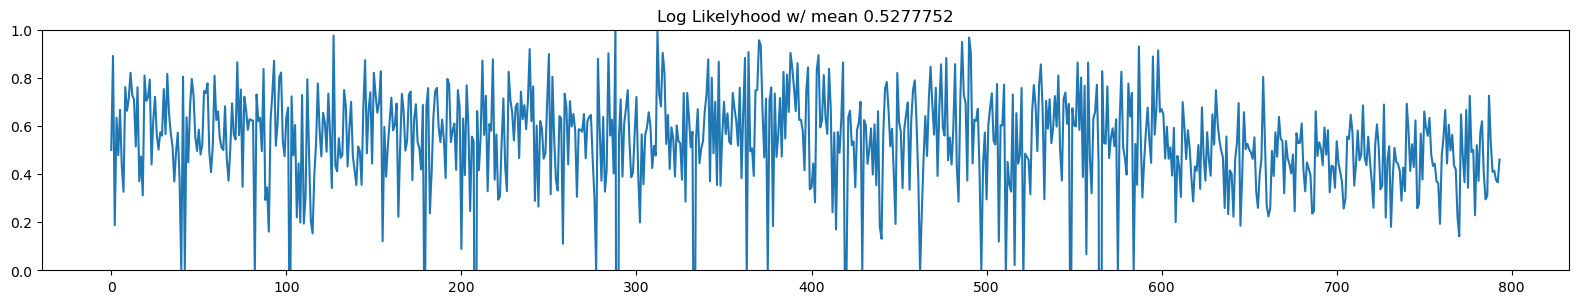

In [60]:
ss()
plt.plot(LL)
plt.title('Log Likelyhood w/ mean '+str(np.mean(LL)))
plt.ylim([0,1])
plt.show()

In [98]:
len(pos_check+neg_check)

88

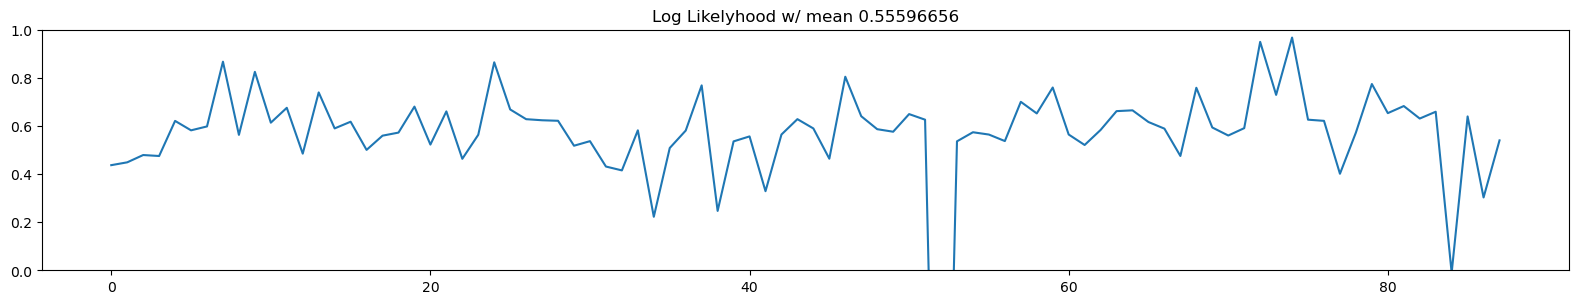

In [99]:
ss()
plt.plot(LL[pos_check+neg_check])
plt.title('Log Likelyhood w/ mean '+str(np.mean(LL[pos_check+neg_check])))
plt.ylim([0,1])
plt.show()

In [100]:
# Readout Weights (i.e. Barcodes)
readout_w = cnn.get_weights(ffnet_target=1)
print(readout_w.shape)

(32, 794)


In [101]:
readout_dist = cos_similarity(readout_w)

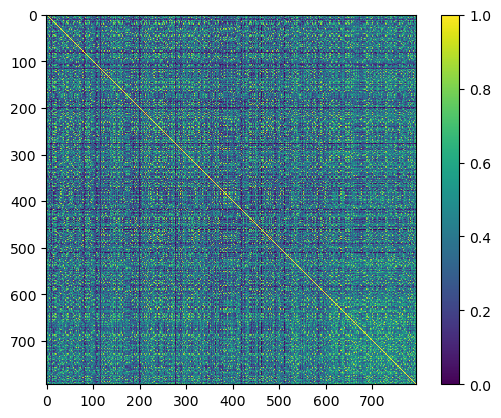

In [103]:
imagesc(readout_dist)
plt.colorbar()
plt.clim(0,1)

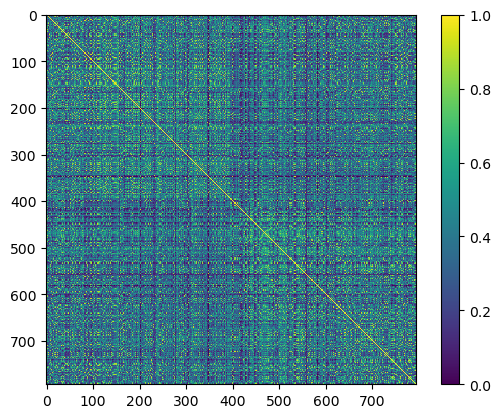

In [105]:
readout_dist_sort = cos_similarity(readout_w[:,np.argsort(pos_corr)])
imagesc(readout_dist_sort)
plt.colorbar()
plt.clim(0,1)